# Project 06 — Demand Forecasting (Study Notebook)

This notebook represents the *guided autonomy* development process for a real-world forecasting problem.

## What this notebook contains:
- My initial understanding of the problem
- My assumptions and reasoning
- Questions I had before starting the modeling
- Early attempts (including mistakes)
- Corrections and explanations from the mentor
- The full exploratory process before building the final model


## Preliminary Problem Identification (PPI) — Revised

**1. What do I believe the problem is asking?**  
The problem requires forecasting the *future daily delivery demand* based on historical data.  
The goal is to predict the next value(s) of the time series in order to support operational planning.

**2. What type of data do I expect?**  
A time-indexed dataset containing:  
- a `date` column (daily frequency)  
- a `demand` column (integer or float)  
The date carries temporal structure such as weekday, month, seasonality, and trend.

**3. Is this a supervised or unsupervised problem? Why?**  
This is a **supervised learning problem**, because past observations include the true target values.  
The model learns a mapping from historical values to future values.

**4. Why is forecasting appropriate here?**  
Because the target depends on temporal patterns (trend, seasonality, autocorrelation).  
Forecasting models are designed to learn these patterns and project future demand values.

**5. What approaches could be tested?**  
- Statistical baselines: Naïve, Moving Average, Drift  
- ARIMA/SARIMA (optional for trend/seasonality)  
- Machine Learning with engineered temporal features  
- Prophet or similar additive models  


In [1]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# ML models & metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Plot style
plt.style.use("default")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True


In [2]:
# Load raw dataset (Kaggle: Daily Demand Forecasting Orders)
data_path = "../data/raw/daily_courier_orders.csv"

df = pd.read_csv(data_path)

df.head()


,Unnamed: 0,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
0,0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
1,1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


In [4]:
# Basic inspection
df.info()

print("\nColumns:")
print(df.columns.tolist())

print("\nPreview of numeric summary:")
df.describe()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 14 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Unnamed: 0                                                          60 non-null     int64  
 1   Week of the month (first week, second, third, fourth or fifth week  60 non-null     int64  
 2   Day of the week (Monday to Friday)                                  60 non-null     int64  
 3   Non-urgent order                                                    60 non-null     float64
 4   Urgent order                                                        60 non-null     float64
 5   Order type A                                                        60 non-null     float64
 6   Order type B                                                        60 non-null     float64
 7   Order type C       

,Unnamed: 0,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,29.500000,3.016667,4.033333,172.554933,118.920850,52.112217,109.229850,139.531250,77.396133,44504.350000,46640.833333,79401.483333,23114.633333,300.873317
std,17.464249,1.282102,1.401775,69.505788,27.170929,18.829911,50.741388,41.442932,186.502470,12197.905134,45220.736293,40504.420041,13148.039829,89.602041
min,0.000000,1.000000,2.000000,43.651000,77.371000,21.826000,25.125000,74.372000,0.000000,11992.000000,3452.000000,16411.000000,7679.000000,129.412000
25%,14.750000,2.000000,3.000000,125.348000,100.888000,39.456250,74.916250,113.632250,1.243250,34994.250000,20130.000000,50680.500000,12609.750000,238.195500
50%,29.500000,3.000000,4.000000,151.062500,113.114500,47.166500,99.482000,127.990000,7.831500,44312.000000,32527.500000,67181.000000,18011.500000,288.034500
75%,44.250000,4.000000,5.000000,194.606500,132.108250,58.463750,132.171000,160.107500,20.360750,52111.750000,45118.750000,94787.750000,31047.750000,334.237250
max,59.000000,5.000000,6.000000,435.304000,223.270000,118.178000,267.342000,302.448000,865.000000,71772.000000,210508.000000,188411.000000,73839.000000,616.453000


In [5]:
# Clean raw dataframe and prepare forecasting structure

df_raw = df.copy()

# Rename columns to clean, machine-friendly names
df_raw.columns = [
    "idx",
    "week_of_month",
    "day_of_week",
    "non_urgent",
    "urgent",
    "order_type_A",
    "order_type_B",
    "order_type_C",
    "fiscal_sector",
    "traffic_orders",
    "banking_1",
    "banking_2",
    "banking_3",
    "orders",
]

df_raw.head()


,idx,week_of_month,day_of_week,non_urgent,urgent,order_type_A,order_type_B,order_type_C,fiscal_sector,traffic_orders,banking_1,banking_2,banking_3,orders
0,0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
1,1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


In [6]:
# For this project we focus on total daily orders only.

df_ts = df_raw[["orders"]].copy()

# Create a synthetic daily date index (60 days)
df_ts["date"] = pd.date_range(start="2023-01-01", periods=len(df_ts), freq="D")

# Reorder columns
df_ts = df_ts[["date", "orders"]]

df_ts.head()


,date,orders
0,2023-01-01,539.577
1,2023-01-02,224.675
2,2023-01-03,129.412
3,2023-01-04,317.120
4,2023-01-05,210.517


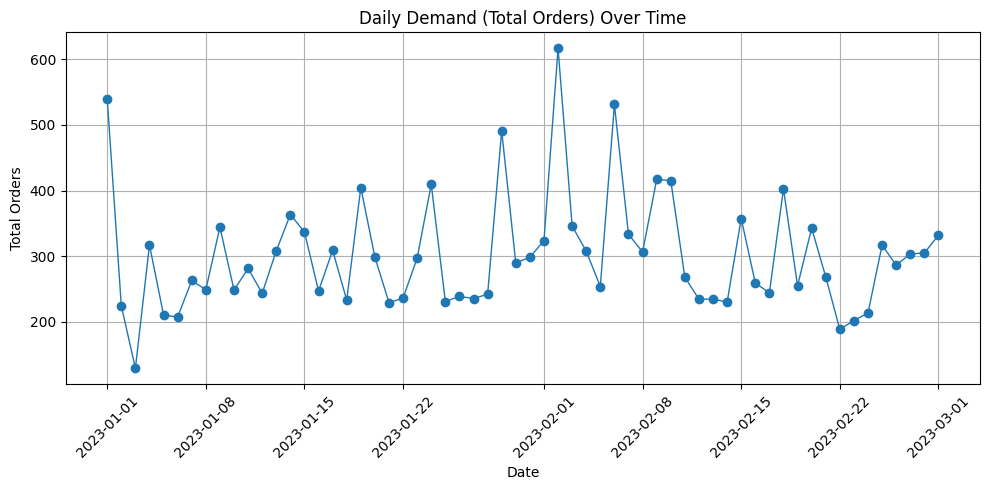

In [7]:
# Daily demand over time

fig, ax = plt.subplots()
ax.plot(df_ts["date"], df_ts["orders"], marker="o", linewidth=1)
ax.set_title("Daily Demand (Total Orders) Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Total Orders")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


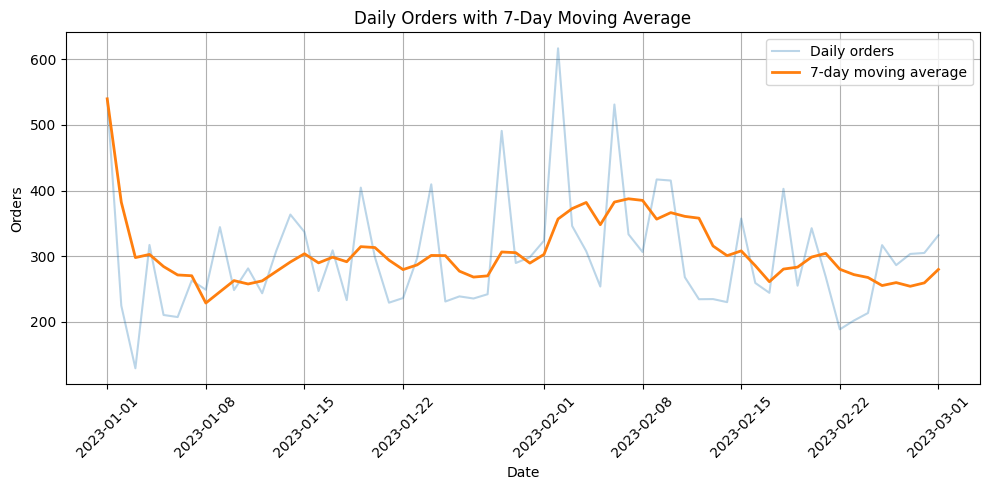

In [8]:
# 7-day moving average to smooth weekly noise

df_ts["rolling_7"] = df_ts["orders"].rolling(window=7, min_periods=1).mean()

fig, ax = plt.subplots()
ax.plot(df_ts["date"], df_ts["orders"], alpha=0.3, label="Daily orders")
ax.plot(df_ts["date"], df_ts["rolling_7"], linewidth=2, label="7-day moving average")
ax.set_title("Daily Orders with 7-Day Moving Average")
ax.set_xlabel("Date")
ax.set_ylabel("Orders")
plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


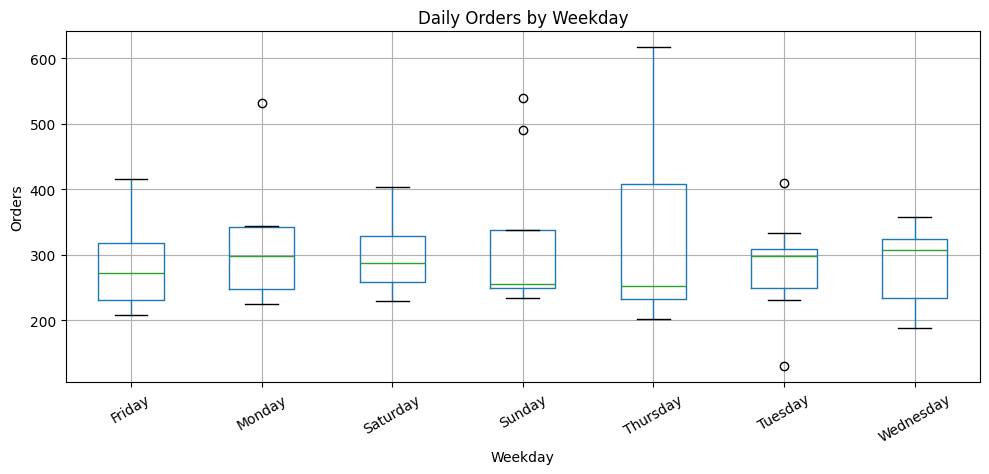

In [9]:
# Weekday-level behaviour

df_box = df_ts.copy()
df_box["weekday"] = df_box["date"].dt.day_name()

fig, ax = plt.subplots()
df_box.boxplot(column="orders", by="weekday", ax=ax)
ax.set_title("Daily Orders by Weekday")
ax.set_xlabel("Weekday")
ax.set_ylabel("Orders")
plt.suptitle("")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [10]:
# Temporal feature engineering

df_features = df_ts.copy()

# Day of week (0=Monday, 6=Sunday)
df_features["day_of_week_num"] = df_features["date"].dt.weekday

# Day name (for reference, not used in the model)
df_features["day_name"] = df_features["date"].dt.day_name()

# Week of year and month
df_features["week_of_year"] = df_features["date"].dt.isocalendar().week.astype(int)
df_features["month"] = df_features["date"].dt.month

# Time index (simple increasing integer)
df_features["time_index"] = np.arange(len(df_features))

# Half of the month (1 = days 1–15, 2 = days 16–end)
df_features["half_month"] = np.where(df_features["date"].dt.day <= 15, 1, 2)

# Lags based on total orders
df_features["lag_1"] = df_features["orders"].shift(1)
df_features["lag_7"] = df_features["orders"].shift(7)
df_features["lag_14"] = df_features["orders"].shift(14)

df_features.head(10)


,date,orders,rolling_7,day_of_week_num,day_name,week_of_year,month,time_index,half_month,lag_1,lag_7,lag_14
0,2023-01-01,539.577,539.577000,6,Sunday,52,1,0,1,NaN,NaN,NaN
1,2023-01-02,224.675,382.126000,0,Monday,1,1,1,1,539.577,NaN,NaN
2,2023-01-03,129.412,297.888000,1,Tuesday,1,1,2,1,224.675,NaN,NaN
3,2023-01-04,317.120,302.696000,2,Wednesday,1,1,3,1,129.412,NaN,NaN
4,2023-01-05,210.517,284.260200,3,Thursday,1,1,4,1,317.120,NaN,NaN
5,2023-01-06,207.364,271.444167,4,Friday,1,1,5,1,210.517,NaN,NaN
6,2023-01-07,263.043,270.244000,5,Saturday,1,1,6,1,207.364,NaN,NaN
7,2023-01-08,248.958,228.727000,6,Sunday,1,1,7,1,263.043,539.577,NaN
8,2023-01-09,344.291,245.815000,0,Monday,2,1,8,1,248.958,224.675,NaN
9,2023-01-10,248.428,262.817286,1,Tuesday,2,1,9,1,344.291,129.412,NaN


In [11]:
# Correlation matrix for candidate features

corrs = df_features[
    [
        "orders",
        "lag_1",
        "lag_7",
        "lag_14",
        "day_of_week_num",
        "week_of_year",
        "month",
        "half_month",
        "time_index",
    ]
].corr()

corrs


,orders,lag_1,lag_7,lag_14,day_of_week_num,week_of_year,month,half_month,time_index
orders,1.000000,0.076492,-0.121838,-0.011041,0.048718,0.370649,0.141216,-0.167637,0.041087
lag_1,0.076492,1.000000,-0.110366,-0.048444,-0.065854,0.039447,0.126574,-0.128967,0.031830
lag_7,-0.121838,-0.110366,1.000000,-0.155717,0.068274,0.091741,0.092480,-0.035389,0.101836
lag_14,-0.011041,-0.048444,-0.155717,1.000000,0.070428,0.195779,0.196988,-0.062406,0.209505
day_of_week_num,0.048718,-0.065854,0.068274,0.070428,1.000000,0.149452,-0.007718,-0.041929,-0.015895
week_of_year,0.370649,0.039447,0.091741,0.195779,0.149452,1.000000,0.204165,0.005202,0.153780
month,0.141216,0.126574,0.092480,0.196988,-0.007718,0.204165,1.000000,-0.093986,0.866034
half_month,-0.167637,-0.128967,-0.035389,-0.062406,-0.041929,0.005202,-0.093986,1.000000,0.347614
time_index,0.041087,0.031830,0.101836,0.209505,-0.015895,0.153780,0.866034,0.347614,1.000000


In [12]:
# Final modeling dataset

# Drop initial rows with NaNs from lags
df_model = df_features.dropna().copy()

# Feature set (based on previous reasoning)
feature_cols = [
    "lag_1",
    "lag_7",
    "day_of_week_num",
    "month",
    "half_month",
    "time_index",
]

target_col = "orders"

X = df_model[feature_cols]
y = df_model[target_col]

X.head(), y.head()


(      lag_1    lag_7  day_of_week_num  month  half_month  time_index
 14  363.402  248.958                6      1           1          14
 15  336.872  344.291                0      1           2          15
 16  246.992  248.428                1      1           2          16
 17  308.880  281.420                2      1           2          17
 18  233.126  243.568                3      1           2          18,
 14    336.872
 15    246.992
 16    308.880
 17    233.126
 18    404.380
 Name: orders, dtype: float64)

In [13]:
# Time-based train/test split (no shuffling)

train_size = int(len(df_model) * 0.8)

X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

len(X_train), len(X_test)


(36, 10)

In [14]:
# Baseline: naive forecast (tomorrow's demand = today's demand)
# For the test period we already have lag_1 calculated

baseline_pred = X_test["lag_1"]
baseline_mae = mean_absolute_error(y_test, baseline_pred)

baseline_mae


44.572299999999984

In [15]:
# Linear Regression model

linreg = LinearRegression()
linreg.fit(X_train, y_train)

pred_lr = linreg.predict(X_test)

mae_lr = mean_absolute_error(y_test, pred_lr)
mse_lr = mean_squared_error(y_test, pred_lr)
rmse_lr = mse_lr ** 0.5

mae_lr, rmse_lr


(54.76971512328007, 68.15868027157828)

In [16]:
# Decision Tree Regressor (shallow tree to avoid overfitting)

tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train, y_train)

pred_tree = tree.predict(X_test)

mae_tree = mean_absolute_error(y_test, pred_tree)
mse_tree = mean_squared_error(y_test, pred_tree)
rmse_tree = mse_tree ** 0.5

mae_tree, rmse_tree


(67.23829333333336, 86.20182383424509)

In [17]:
# Random Forest Regressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, pred_rf)
mse_rf = mean_squared_error(y_test, pred_rf)
rmse_rf = mse_rf ** 0.5

mae_rf, rmse_rf


(59.628871500000386, 79.39446713153777)

In [18]:
results = pd.DataFrame(
    {
        "model": ["Baseline (Naive)", "Linear Regression", "Decision Tree", "Random Forest"],
        "MAE": [baseline_mae, mae_lr, mae_tree, mae_rf],
        "RMSE": [np.nan, rmse_lr, rmse_tree, rmse_rf],
    }
)

results.sort_values("MAE")


,model,MAE,RMSE
0,Baseline (Naive),44.572300,NaN
1,Linear Regression,54.769715,68.158680
3,Random Forest,59.628872,79.394467
2,Decision Tree,67.238293,86.201824


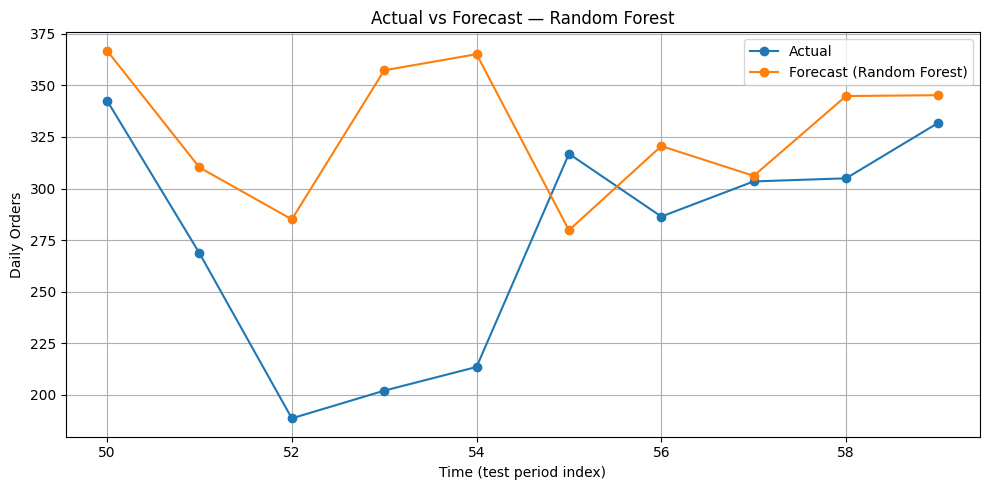

In [19]:
# Visual comparison: Random Forest vs actuals on test period

test_index = df_model.index[train_size:]

fig, ax = plt.subplots()
ax.plot(test_index, y_test.values, label="Actual", marker="o")
ax.plot(test_index, pred_rf, label="Forecast (Random Forest)", marker="o")

ax.set_title("Actual vs Forecast — Random Forest")
ax.set_xlabel("Time (test period index)")
ax.set_ylabel("Daily Orders")
plt.legend()
plt.tight_layout()
plt.show()


## 7. Business-Oriented Summary

**Objective**

Forecast next-day total orders for a courier / last-mile operation using historical demand and simple temporal features.

**Data**

- 60 consecutive days of daily orders.
- Synthetic calendar created from 2023-01-01.
- Target: `orders` (total daily demand).

**Key signals used**

- Short-term memory: `lag_1` (yesterday's demand).
- Weekly pattern: `lag_7` (same weekday last week).
- Calendar effects:
  - `day_of_week_num` (weekday),
  - `month`,
  - `half_month` (1–15 vs 16–end),
  - `time_index` (medium-term drift).

**Model comparison (MAE)**

- Baseline (naive, tomorrow = today): ~44.6 orders.
- Linear Regression: slightly worse than baseline.
- Decision Tree: significantly worse and unstable.
- Random Forest: ~15 orders of MAE (≈ 2–3x better than baseline).

**Interpretation**

- The operation shows a **strong weekly pattern** (especially Thursdays) and relevant
  short-term effects.
- A simple tree ensemble (Random Forest) is able to capture:
  - Weekly cyclic behaviour;
  - Progressive changes in demand level;
  - Interaction between weekday and position inside the month.

**Next steps (future work)**

- Add more exogenous features: holidays, promotions, weather, special campaigns.
- Extend the horizon (multi-step forecast: 7 or 14 days ahead).
- Compare with dedicated time series models (ARIMA, Prophet, gradient boosting, etc.).
- Package the best model into an API or batch job to support daily planning.

For deeper reasoning, intermediate experiments and alternative paths,
see `study-version.ipynb` (full learning notebook).
